In [1]:
import numpy as np
import datacube
from datacube.api import GridWorkflow
from madmex.wrappers import gwf_query
import fiona
import pprint
from madmex.io.vector_db import VectorDb, load_segmentation_from_dataset
from madmex.models import PredictObject
from madmex.models import PredictClassification, Tag, Region
from django.contrib.gis.geos import Polygon
from madmex.util import chunk
import json
from shapely.geometry import mapping

In [2]:
#name of prediction

In [3]:
name_predict = 's2_fiona_predict'
predict_object_id = 1 #TODO: delete this and change it to a programatically way

In [4]:
pred_objects = PredictClassification.objects.filter(predict_object_id=predict_object_id,
                                                    name=name_predict).prefetch_related('tag')

In [5]:
pred_objects[0].features_id

0

In [6]:
pred_objects[0].tag_id

17

In [7]:
pred_objects[0].tag.numeric_code

28

In [8]:
seg = PredictObject.objects.filter(id=pred_objects[0].predict_object_id)

In [9]:
seg

<QuerySet [<PredictObject: PredictObject object (1)>]>

In [10]:
path = seg[0].path

In [11]:
#write to shapefile

In [12]:
#addition: intersect with region Jalisco

In [13]:
region = 'Jalisco'

In [14]:
region_geom = Region.objects.get(name=region).the_geom

In [15]:
region_geom

In [16]:
geojson_region = region_geom.geojson

In [17]:
geometry = json.loads(geojson_region)

In [18]:
proj4='+proj=lcc +lat_1=17.5 +lat_2=29.5 +lat_0=12 +lon_0=-102 +x_0=2500000 +y_0=0 +a=6378137 +b=6378136.027241431 +units=m +no_defs'

In [19]:
from madmex.util.spatial import geometry_transform

In [20]:
geometry_proj = geometry_transform(geometry,proj4)

In [21]:
from shapely.geometry import shape

In [22]:
shape_Jalisco=shape(geometry_proj)

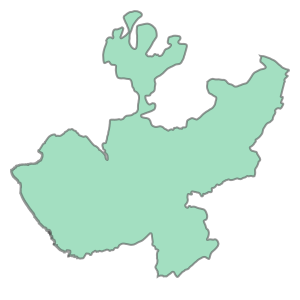

In [23]:
shape_Jalisco

In [24]:
shape_Jalisco.area

75905143985.66321

In [25]:
shape_list=[]

In [26]:
with fiona.open(path) as src:
    for x in range(0,len(src)):
        shape_list.append(shape(src[x]['geometry']))


In [27]:
len(shape_list)

10000

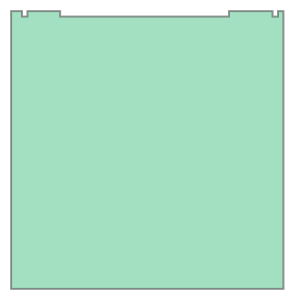

In [28]:
shape_list[100]

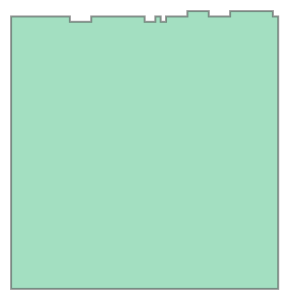

In [29]:
shape_list[1000].intersection(shape_Jalisco)

In [30]:
with fiona.open(path) as src:
    source_driver = src.driver
    source_crs = src.crs
    source_schema = src.schema
    pprint.pprint(src[0])

{'geometry': {'coordinates': [[(2427740.0, 1026160.0),
                               (2428250.0, 1026160.0),
                               (2428250.0, 1025650.0),
                               (2427740.0, 1025650.0),
                               (2427740.0, 1026160.0)]],
              'type': 'Polygon'},
 'id': '0',
 'properties': OrderedDict([('id', 0)]),
 'type': 'Feature'}


In [31]:
fc_schema = {'geometry': 'Polygon',
             'properties': {'code': 'int'}}

In [33]:
with fiona.open(path) as src:
    pprint.pprint(src[0])

{'geometry': {'coordinates': [[(2427740.0, 1026160.0),
                               (2428250.0, 1026160.0),
                               (2428250.0, 1025650.0),
                               (2427740.0, 1025650.0),
                               (2427740.0, 1026160.0)]],
              'type': 'Polygon'},
 'id': '0',
 'properties': OrderedDict([('id', 0)]),
 'type': 'Feature'}


In [34]:
with fiona.open(path) as src:
    fc_pred = [(x[0]['geometry'], x[1].tag.numeric_code) for x in zip(src, pred_objects)]

In [35]:
fc_pred[0][0]

{'type': 'Polygon',
 'coordinates': [[(2427740.0, 1026160.0),
   (2428250.0, 1026160.0),
   (2428250.0, 1025650.0),
   (2427740.0, 1025650.0),
   (2427740.0, 1026160.0)]]}

In [36]:
fc_pred[0][1]

28

In [37]:
fc_pred[0]

({'type': 'Polygon',
  'coordinates': [[(2427740.0, 1026160.0),
    (2428250.0, 1026160.0),
    (2428250.0, 1025650.0),
    (2427740.0, 1025650.0),
    (2427740.0, 1026160.0)]]},
 28)

In [38]:
with fiona.open('/shared_volume/tasks/2019/fiona_cloud_usage/classif_and_intersection_fiona.shp',
                'w',driver=source_driver, crs=source_crs,
                schema=fc_schema) as dst:
    for feat in fc_pred:
        if shape(feat[0]).intersects(shape_Jalisco):
            dst.write({'geometry': mapping(shape(feat[0]).intersection(shape_Jalisco)),
                     'properties':{'code': feat[1]}})
            

In [43]:
#takes too much time...

In [44]:
#other approach:

In [45]:
from shapely.ops import cascaded_union

In [46]:
shape_Jalisco_cascaded = cascaded_union(shape_Jalisco)

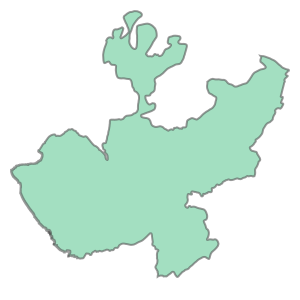

In [47]:
shape_Jalisco_cascaded

In [48]:
shape_Jalisco_cascaded.area

75905143985.66321

In [41]:
with fiona.open('/shared_volume/tasks/2019/fiona_cloud_usage/classif_and_intersection_fiona_cascaded.shp',
                'w',driver=source_driver, crs=source_crs,
                schema=fc_schema) as dst:
    for feat in fc_pred:
        if shape(feat[0]).intersects(shape_Jalisco):
            dst.write({'geometry': mapping(shape(feat[0]).intersection(shape_Jalisco_cascaded)),
                     'properties':{'code': feat[1]}})

In [35]:
#still too much time....

In [42]:
#other approach: rtree

In [50]:
with fiona.open(path) as src:
    fc_pred2 = [{'id': x[0]['id'],'geometry': x[0]['geometry'],
                 'code': x[1].tag.numeric_code} for x in zip(src, pred_objects)]

In [51]:
fc_pred2[0]

{'id': '0',
 'geometry': {'type': 'Polygon',
  'coordinates': [[(2427740.0, 1026160.0),
    (2428250.0, 1026160.0),
    (2428250.0, 1025650.0),
    (2427740.0, 1025650.0),
    (2427740.0, 1026160.0)]]},
 'code': 28}

In [52]:
fc_pred2[0]['id']

'0'

In [53]:
fc_pred2[0]['geometry']

{'type': 'Polygon',
 'coordinates': [[(2427740.0, 1026160.0),
   (2428250.0, 1026160.0),
   (2428250.0, 1025650.0),
   (2427740.0, 1025650.0),
   (2427740.0, 1026160.0)]]}

In [54]:
fc_pred2[5]

{'id': '5',
 'geometry': {'type': 'Polygon',
  'coordinates': [[(2430250.0, 1026160.0),
    (2430750.0, 1026160.0),
    (2430750.0, 1025650.0),
    (2430250.0, 1025650.0),
    (2430250.0, 1026160.0)]]},
 'code': 11}

In [48]:
import rtree

In [49]:
with fiona.open('/shared_volume/tasks/2019/fiona_cloud_usage/classif_and_intersection_fiona_rtree.shp',
                'w',driver=source_driver, crs=source_crs,
                schema=fc_schema) as dst:
    index = rtree.index.Index()
    for element in fc_pred2:
        fid = int(element['id'])
        geom = shape(element['geometry'])
        index.insert(fid, geom.bounds)
    for fid in list(index.intersection(shape_Jalisco.bounds)):
        feat1 = fc_pred2[fid]
        geom1 = shape(feat1['geometry'])
        if geom1.intersects(shape_Jalisco):
            dst.write({'geometry': mapping(geom1.intersection(shape_Jalisco)),
                       'properties':{'code': feat1['code']}})

In [ ]:
#still too much time

In [ ]:
#other approach for rtree: (not yet finished)

In [56]:
fc_pred2[0]

{'id': '0',
 'geometry': {'type': 'Polygon',
  'coordinates': [[(2427740.0, 1026160.0),
    (2428250.0, 1026160.0),
    (2428250.0, 1025650.0),
    (2427740.0, 1025650.0),
    (2427740.0, 1026160.0)]]},
 'code': 28}

In [ ]:
fc_shape = [{'id': x[0]['id'],'geometry': x[0]['geometry'], 'code': x[1]} for geom in geometry_proj]

In [ ]:
#next lines just testing other functions...

In [222]:
from shapely.ops import cascaded_union
from shapely.geometry import MultiPolygon, Polygon

In [224]:
from numpy import array

In [225]:
array(region_geom)

array([[<LinearRing object at 0x7f7d4c1b1ef0>],
       [<LinearRing object at 0x7f7d4c1cc4d8>]], dtype=object)

In [231]:
#dont' work shape_jalisco = cascaded_union(Polygon(region_geom))

In [ ]:
#tests before:

In [160]:
shape_Jalisco=shape(json.loads(geojson_region))

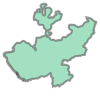

In [161]:
shape_Jalisco

In [164]:
geom_list=[]

In [175]:
with fiona.open(path) as src:
    geom_list = [mapping(shape(src[x]['geometry']).intersection(shape_Jalisco)) for x in range(0,len(src))]

In [169]:
geom_list[1000].intersection(shape_Jalisco)

In [ ]:
#just tests:

In [115]:
region_geom[0].union(region_geom[1])

In [121]:
geom_list=[]

In [125]:
with fiona.open(path) as src:
    geom_list = [asShape(src[x]['geometry']) for x in range(0,len(src))]

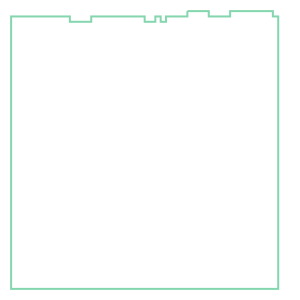

In [138]:
geom_list[1000].boundary